In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.initializers import HeNormal
from keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [48]:
max_pad_len = 174
num_rows = 40
num_columns = 174
num_channels = 1
num_epochs = 100
num_batch_size = 256
dataset_path = './audio/'
metadata = pd.read_csv('./metadata/UrbanSound8K.csv')

In [3]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_rows)
        pad_width = max_pad_len - mfccs.shape[1]
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file:", file_name)
        return None
    return mfccs

In [4]:
# Label encode outside the loop for consistency
le = LabelEncoder()
le.fit(metadata["class"])
num_labels = len(le.classes_)

In [5]:
# Store accuracy of each fold
fold_accuracies = []

# Save model and track training accuracy
train_accuracies = []

In [6]:
data_1 = metadata[metadata['fold'] == 1]
data_2 = metadata[metadata['fold'] == 2]
data_3 = metadata[metadata['fold'] == 3]
data_4 = metadata[metadata['fold'] == 4]
data_5 = metadata[metadata['fold'] == 5]
data_6 = metadata[metadata['fold'] == 6]
data_7 = metadata[metadata['fold'] == 7]
data_8 = metadata[metadata['fold'] == 8]
data_9 = metadata[metadata['fold'] == 9]
data_10 = metadata[metadata['fold'] == 10]
data_folds = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]

In [7]:
data_1

,slice_file_name,fsID,start,end,salience,fold,classID,class
64,101415-3-0-2.wav,101415,1.000000,5.000000,1,1,3,dog_bark
65,101415-3-0-3.wav,101415,1.500000,5.500000,1,1,3,dog_bark
66,101415-3-0-8.wav,101415,4.000000,8.000000,1,1,3,dog_bark
105,102106-3-0-0.wav,102106,2.243852,3.884477,2,1,3,dog_bark
106,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
...,...,...,...,...,...,...,...,...
8676,99180-9-0-2.wav,99180,1.000000,5.000000,1,1,9,street_music
8677,99180-9-0-36.wav,99180,18.000000,22.000000,1,1,9,street_music
8678,99180-9-0-48.wav,99180,24.000000,28.000000,1,1,9,street_music
8679,99180-9-0-49.wav,99180,24.500000,28.500000,1,1,9,street_music


In [8]:
def extract_set(dataframe):
    features = []
    labels = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Extracting features"):
        file_path = os.path.join(dataset_path, f"fold{row['fold']}", row["slice_file_name"])
        class_label = row["class"]
        data = extract_features(file_path)
        if data is not None:
            features.append([data, class_label])
            labels.append(row["class"])
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
    return features, featuresdf

In [9]:
features_1, featuresdf_1 = extract_set(data_1)
features_2, featuresdf_2 = extract_set(data_2)
features_3, featuresdf_3 = extract_set(data_3)
features_4, featuresdf_4 = extract_set(data_4)
features_5, featuresdf_5 = extract_set(data_5)
features_6, featuresdf_6 = extract_set(data_6)
features_7, featuresdf_7 = extract_set(data_7)
features_8, featuresdf_8 = extract_set(data_8)
features_9, featuresdf_9 = extract_set(data_9)
features_10, featuresdf_10 = extract_set(data_10)

all_features = [features_1, features_2, features_3, features_4, features_5, features_6, features_7, features_8, features_9, features_10]

all_features_df = [featuresdf_1, featuresdf_2, featuresdf_3, featuresdf_4, featuresdf_5, featuresdf_6, featuresdf_7, featuresdf_8, featuresdf_9, featuresdf_10]

Extracting features:  95%|█████████▌| 831/873 [01:10<00:02, 20.47it/s]C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
Extracting features:  96%|█████████▌| 834/873 [01:10<00:01, 21.78it/s]C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
Extracting features: 100%|██████████| 837/837 [01:14<00:00, 11.24it/s]


In [10]:
featuresdf_1

,feature,class_label
0,"[[-525.06586, -519.55695, -518.64276, -518.897...",dog_bark
1,"[[-524.8159, -521.7542, -520.1264, -521.55524,...",dog_bark
2,"[[-133.84369, -161.87689, -246.68976, -244.979...",dog_bark
3,"[[-268.53568, -244.676, -250.90111, -222.67284...",dog_bark
4,"[[-145.07484, -90.33111, -93.73102, -105.46187...",gun_shot
...,...,...
868,"[[-156.50749, -163.36191, -215.15918, -218.828...",street_music
869,"[[-123.989105, -134.89343, -156.30284, -154.51...",street_music
870,"[[-162.53307, -154.248, -156.98843, -153.72377...",street_music
871,"[[-101.44252, -102.41235, -158.99976, -152.564...",street_music


In [11]:
# Combine all data to get consistent label encoding
all_labels = [label for df in all_features_df for label in df['class_label']]
le = LabelEncoder()
le.fit(all_labels)  # Fit once across all data

X_folds = []
y_folds = []

for features_df in all_features_df:
    X = np.array(features_df['feature'].tolist())
    y = le.transform(features_df['class_label'])  # Encode
    y = to_categorical(y)  # One-hot
    X_folds.append(X)
    y_folds.append(y)


In [12]:
def build_model(input_shape, num_labels):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model


In [50]:
def run_fold(fold_number):
    test_x = X_folds[fold_number - 1]
    test_y = y_folds[fold_number - 1]

    train_x = np.concatenate([X_folds[i] for i in range(10) if i != (fold_number - 1)], axis=0)
    train_y = np.concatenate([y_folds[i] for i in range(10) if i != (fold_number - 1)], axis=0)

    print(train_x.shape)
    print(test_x.shape)
    print(train_y.shape)
    print(test_y.shape)

    x_train = train_x.reshape(train_x.shape[0], num_rows, num_columns, num_channels)
    x_test = test_x.reshape(test_x.shape[0], num_rows, num_columns, num_channels)

    y_train_cat = train_y
    y_test_cat = test_y

    # Optional normalization (you may shift this to extract_features if better)
    x_train = (x_train - np.mean(x_train)) / np.std(x_train)
    x_test = (x_test - np.mean(x_test)) / np.std(x_test)

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', train_y.shape)
    print('y_test shape:', test_y.shape)

    model = build_model((num_rows, num_columns, num_channels), num_labels)

    # Compute class weights
    y_train_labels = np.argmax(y_train_cat, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))

    # Callbacks
    checkpoint_path = f"saved_models/weights.fold{fold_number}.best.keras"
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    print(f"\nTraining Fold {fold_number}...")
    start = datetime.now()

    history = model.fit(
        x_train, y_train_cat,
        batch_size=num_batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test_cat),
        class_weight=class_weight_dict,
        callbacks=[checkpointer, earlystopper, lr_scheduler],
        verbose=1
    )

    duration = datetime.now() - start
    print(f"Fold {fold_number} training completed in time: {duration}")

    # Save final model
    final_model_path = f"saved_models/urban_sound_model_fold{fold_number}.final.keras"
    model.save(final_model_path)

    # Post-training evaluation
    train_accuracy = history.history['accuracy'][-1]
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nFold {fold_number} Post-Training Train Accuracy: {train_accuracy:.4f}")
    print(f"Fold {fold_number} Post-Training Test Accuracy: {test_accuracy:.4f}")
    print(model.evaluate(x_test, y_test_cat, verbose=0))

    return train_accuracy, test_accuracy

In [61]:
def run_combined():
    # Combine all folds into one dataset
    X = np.concatenate(X_folds, axis=0)
    y = np.concatenate(y_folds, axis=0)  # Assume already one-hot encoded

    num_labels = y.shape[1]

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=np.argmax(y, axis=1))

    # Reshape for CNN
    x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
    x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

    # Optional normalization (uncomment if needed)
    x_train = (x_train - np.mean(x_train)) / np.std(x_train)
    x_test = (x_test - np.mean(x_test)) / np.std(x_test)

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)

    # Ensure save directory exists
    os.makedirs("saved_models", exist_ok=True)

    # Build model
    model = build_model((num_rows, num_columns, num_channels), num_labels)

    # Compute class weights
    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))

    # Callbacks
    checkpoint_path = "saved_models/weights.combined.best.keras"
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    # Train
    print("\nTraining Combined dataset...")
    start = datetime.now()

    history = model.fit(
        x_train, y_train,
        batch_size=num_batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        class_weight=class_weight_dict,
        callbacks=[checkpointer, earlystopper, lr_scheduler],
        verbose=1
    )

    duration = datetime.now() - start
    print(f"Training completed in time: {duration}")

    # Save final model
    final_model_path = "saved_models/urban_sound_model_combined.final.keras"
    model.save(final_model_path)

    # Post-training evaluation
    train_accuracy = history.history['accuracy'][-1]
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(y_true, y_pred)

    print(f"\nPost-Training Train Accuracy: {train_accuracy:.4f}")
    print(f"Post-Training Test Accuracy: {test_accuracy:.4f}")
    print("Evaluation:", model.evaluate(x_test, y_test, verbose=0))

    return train_accuracy, test_accuracy

In [62]:
train_accuracy, test_accuracy = run_combined()
print(train_accuracy)
print(test_accuracy)

x_train shape: (7858, 40, 174, 1)
x_test shape: (874, 40, 174, 1)
y_train shape: (7858, 10)
y_test shape: (874, 10)


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Combined dataset...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.1319 - loss: 2.2368
Epoch 1: val_loss improved from inf to 2.02181, saving model to saved_models/weights.combined.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.1336 - loss: 2.2351 - val_accuracy: 0.3593 - val_loss: 2.0218 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3380 - loss: 1.9205
Epoch 2: val_loss improved from 2.02181 to 1.69353, saving model to saved_models/weights.combined.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - accuracy: 0.3389 - loss: 1.9179 - val_accuracy: 0.4657 - val_loss: 1.6935 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4687 - loss: 1.5988
Epoch 3: val_loss improved from 1.69353 to 1.51963, saving model to saved_models/weights.combined.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.4693 - loss: 1.5968 - val_accuracy: 0.4886 - v

In [51]:
train_accuracy, test_accuracy = run_fold(1)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7859, 40, 174)
(873, 40, 174)
(7859, 10)
(873, 10)
x_train shape: (7859, 40, 174, 1)
x_test shape: (873, 40, 174, 1)
y_train shape: (7859, 10)
y_test shape: (873, 10)


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Fold 1...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.1595 - loss: 2.2361
Epoch 1: val_loss improved from inf to 2.05845, saving model to saved_models/weights.fold1.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.1614 - loss: 2.2338 - val_accuracy: 0.2806 - val_loss: 2.0584 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3506 - loss: 1.8711
Epoch 2: val_loss improved from 2.05845 to 1.89391, saving model to saved_models/weights.fold1.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.3514 - loss: 1.8687 - val_accuracy: 0.4261 - val_loss: 1.8939 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4689 - loss: 1.5425
Epoch 3: val_loss improved from 1.89391 to 1.73922, saving model to saved_models/weights.fold1.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.4695 - loss: 1.5405 - val_accuracy: 0.4364 - val_loss: 1.7392 - lea

In [52]:
train_accuracy, test_accuracy = run_fold(2)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7844, 40, 174)
(888, 40, 174)
(7844, 10)
(888, 10)
x_train shape: (7844, 40, 174, 1)
x_test shape: (888, 40, 174, 1)
y_train shape: (7844, 10)
y_test shape: (888, 10)

Training Fold 2...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1353 - loss: 2.2407
Epoch 1: val_loss improved from inf to 1.96520, saving model to saved_models/weights.fold2.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.1373 - loss: 2.2387 - val_accuracy: 0.3592 - val_loss: 1.9652 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3733 - loss: 1.8236
Epoch 2: val_loss improved from 1.96520 to 1.63172, saving model to saved_models/weights.fold2.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.3744 - loss: 1.8202 - val_accuracy: 0.4279 - val_loss: 1.6317 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4723 - loss: 1.5020
Epoch 3: val_loss improved from 1.63172 to 1.57146, saving model to saved_models/weights.fold2.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.4730 - loss: 1.5001 - val_accuracy: 0.4628 - val_loss: 1.5715 - learning_rate: 0.0010
E

In [53]:
train_accuracy, test_accuracy = run_fold(3)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7807, 40, 174)
(925, 40, 174)
(7807, 10)
(925, 10)
x_train shape: (7807, 40, 174, 1)
x_test shape: (925, 40, 174, 1)
y_train shape: (7807, 10)
y_test shape: (925, 10)

Training Fold 3...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1477 - loss: 2.2306
Epoch 1: val_loss improved from inf to 2.06399, saving model to saved_models/weights.fold3.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.1492 - loss: 2.2278 - val_accuracy: 0.2011 - val_loss: 2.0640 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3605 - loss: 1.8398
Epoch 2: val_loss improved from 2.06399 to 1.81927, saving model to saved_models/weights.fold3.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.3613 - loss: 1.8367 - val_accuracy: 0.3232 - val_loss: 1.8193 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4685 - loss: 1.4715
Epoch 3: val_loss improved from 1.81927 to 1.64063, saving model to saved_models/weights.fold3.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.4690 - loss: 1.4705 - val_accuracy: 0.4000 - val_loss: 1.6406 - learning_rate: 0.0010


In [54]:
train_accuracy, test_accuracy = run_fold(4)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7742, 40, 174)
(990, 40, 174)
(7742, 10)
(990, 10)
x_train shape: (7742, 40, 174, 1)
x_test shape: (990, 40, 174, 1)
y_train shape: (7742, 10)
y_test shape: (990, 10)

Training Fold 4...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.1371 - loss: 2.2394
Epoch 1: val_loss improved from inf to 2.02662, saving model to saved_models/weights.fold4.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.1390 - loss: 2.2370 - val_accuracy: 0.2586 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3498 - loss: 1.8144
Epoch 2: val_loss improved from 2.02662 to 1.64752, saving model to saved_models/weights.fold4.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.3508 - loss: 1.8120 - val_accuracy: 0.4556 - val_loss: 1.6475 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4628 - loss: 1.4690
Epoch 3: val_loss improved from 1.64752 to 1.50269, saving model to saved_models/weights.fold4.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.4635 - loss: 1.4675 - val_accuracy: 0.4798 - val_loss: 1.5027 - learning_rate: 0.0010

In [55]:
train_accuracy, test_accuracy = run_fold(5)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7796, 40, 174)
(936, 40, 174)
(7796, 10)
(936, 10)
x_train shape: (7796, 40, 174, 1)
x_test shape: (936, 40, 174, 1)
y_train shape: (7796, 10)
y_test shape: (936, 10)

Training Fold 5...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1505 - loss: 2.2479
Epoch 1: val_loss improved from inf to 1.95827, saving model to saved_models/weights.fold5.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.1525 - loss: 2.2451 - val_accuracy: 0.3045 - val_loss: 1.9583 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3845 - loss: 1.8256
Epoch 2: val_loss improved from 1.95827 to 1.64503, saving model to saved_models/weights.fold5.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.3853 - loss: 1.8236 - val_accuracy: 0.3761 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4773 - loss: 1.5120
Epoch 3: val_loss improved from 1.64503 to 1.50889, saving model to saved_models/weights.fold5.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.4777 - loss: 1.5104 - val_accuracy: 0.4199 - val_loss: 1.5089 - learning_rate: 0.0010
E

In [56]:
train_accuracy, test_accuracy = run_fold(6)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7909, 40, 174)
(823, 40, 174)
(7909, 10)
(823, 10)
x_train shape: (7909, 40, 174, 1)
x_test shape: (823, 40, 174, 1)
y_train shape: (7909, 10)
y_test shape: (823, 10)


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Fold 6...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1343 - loss: 2.2724
Epoch 1: val_loss improved from inf to 2.03259, saving model to saved_models/weights.fold6.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.1359 - loss: 2.2697 - val_accuracy: 0.2746 - val_loss: 2.0326 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3544 - loss: 1.8580
Epoch 2: val_loss improved from 2.03259 to 1.76779, saving model to saved_models/weights.fold6.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.3555 - loss: 1.8551 - val_accuracy: 0.4399 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.4754 - loss: 1.5068
Epoch 3: val_loss improved from 1.76779 to 1.53207, saving model to saved_models/weights.fold6.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.4758 - loss: 1.5046 - val_accuracy: 0.5006 - val_loss: 1.5321 - l

In [57]:
train_accuracy, test_accuracy = run_fold(7)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7894, 40, 174)
(838, 40, 174)
(7894, 10)
(838, 10)
x_train shape: (7894, 40, 174, 1)
x_test shape: (838, 40, 174, 1)
y_train shape: (7894, 10)
y_test shape: (838, 10)

Training Fold 7...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.1569 - loss: 2.2173
Epoch 1: val_loss improved from inf to 1.93765, saving model to saved_models/weights.fold7.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.1588 - loss: 2.2146 - val_accuracy: 0.2983 - val_loss: 1.9377 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3749 - loss: 1.7972
Epoch 2: val_loss improved from 1.93765 to 1.64848, saving model to saved_models/weights.fold7.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.3758 - loss: 1.7953 - val_accuracy: 0.3807 - val_loss: 1.6485 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4800 - loss: 1.5246
Epoch 3: val_loss improved from 1.64848 to 1.42071, saving model to saved_models/weights.fold7.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.4805 - loss: 1.5228 - val_accuracy: 0.4940 - val_loss: 1.4207 - learning_rate: 0.0010
E

In [58]:
train_accuracy, test_accuracy = run_fold(8)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7926, 40, 174)
(806, 40, 174)
(7926, 10)
(806, 10)
x_train shape: (7926, 40, 174, 1)
x_test shape: (806, 40, 174, 1)
y_train shape: (7926, 10)
y_test shape: (806, 10)

Training Fold 8...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.1652 - loss: 2.2154
Epoch 1: val_loss improved from inf to 1.95021, saving model to saved_models/weights.fold8.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.1668 - loss: 2.2128 - val_accuracy: 0.3970 - val_loss: 1.9502 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3517 - loss: 1.8176
Epoch 2: val_loss improved from 1.95021 to 1.68959, saving model to saved_models/weights.fold8.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.3530 - loss: 1.8149 - val_accuracy: 0.4888 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4730 - loss: 1.5029
Epoch 3: val_loss improved from 1.68959 to 1.49662, saving model to saved_models/weights.fold8.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.4733 - loss: 1.5017 - val_accuracy: 0.5831 - val_loss: 1.4966 - learning_rate: 0.0010
E

In [59]:
train_accuracy, test_accuracy = run_fold(9)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7916, 40, 174)
(816, 40, 174)
(7916, 10)
(816, 10)
x_train shape: (7916, 40, 174, 1)
x_test shape: (816, 40, 174, 1)
y_train shape: (7916, 10)
y_test shape: (816, 10)

Training Fold 9...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.1242 - loss: 2.2761
Epoch 1: val_loss improved from inf to 2.03719, saving model to saved_models/weights.fold9.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.1257 - loss: 2.2737 - val_accuracy: 0.2733 - val_loss: 2.0372 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3570 - loss: 1.9083
Epoch 2: val_loss improved from 2.03719 to 1.71544, saving model to saved_models/weights.fold9.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.3580 - loss: 1.9048 - val_accuracy: 0.3493 - val_loss: 1.7154 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4549 - loss: 1.5270
Epoch 3: val_loss improved from 1.71544 to 1.47289, saving model to saved_models/weights.fold9.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.4555 - loss: 1.5248 - val_accuracy: 0.4350 - val_loss: 1.4729 - learning_rate: 0.0010
E

In [60]:
train_accuracy, test_accuracy = run_fold(10)
train_accuracies.append(train_accuracy)
fold_accuracies.append(test_accuracy)

(7895, 40, 174)
(837, 40, 174)
(7895, 10)
(837, 10)
x_train shape: (7895, 40, 174, 1)
x_test shape: (837, 40, 174, 1)
y_train shape: (7895, 10)
y_test shape: (837, 10)


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Fold 10...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.1490 - loss: 2.2309
Epoch 1: val_loss improved from inf to 2.07343, saving model to saved_models/weights.fold10.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.1504 - loss: 2.2287 - val_accuracy: 0.3082 - val_loss: 2.0734 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3347 - loss: 1.9264
Epoch 2: val_loss improved from 2.07343 to 1.83637, saving model to saved_models/weights.fold10.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.3352 - loss: 1.9242 - val_accuracy: 0.3357 - val_loss: 1.8364 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4128 - loss: 1.6695
Epoch 3: val_loss improved from 1.83637 to 1.66558, saving model to saved_models/weights.fold10.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.4133 - loss: 1.6674 - val_accuracy: 0.4361 - val_loss: 1.6656 -

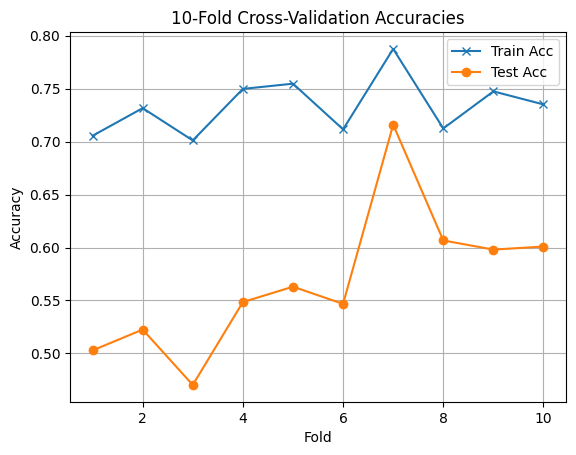

Train Accuracies: [0.7055605053901672, 0.7316420078277588, 0.7011656165122986, 0.7498062252998352, 0.7547460198402405, 0.7115944027900696, 0.7875601649284363, 0.7124652862548828, 0.7474734783172607, 0.7351488471031189]
Test Accuracies: [0.5028636884306987, 0.5225225225225225, 0.4702702702702703, 0.5484848484848485, 0.563034188034188, 0.5467800729040098, 0.7159904534606205, 0.6066997518610422, 0.5980392156862745, 0.6009557945041816]


In [27]:
plt.plot(range(1, 11), train_accuracies, 'x-', label="Train Acc")
plt.plot(range(1, 11), fold_accuracies, 'o-', label="Test Acc")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("10-Fold Cross-Validation Accuracies")
plt.legend()
plt.grid()
plt.show()

print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", fold_accuracies)

In [28]:
# Final metrics
print(f"\nAverage Training Accuracy over 10 folds: {np.mean(train_accuracies):.4f}")
print(f"Average Test Accuracy over 10 folds: {np.mean(fold_accuracies):.4f}")
print(f"Training Accuracies for each fold: {train_accuracies}")
print(f"Test Accuracies for each fold: {fold_accuracies}")


Average Training Accuracy over 10 folds: 0.7337
Average Test Accuracy over 10 folds: 0.5676
Training Accuracies for each fold: [0.7055605053901672, 0.7316420078277588, 0.7011656165122986, 0.7498062252998352, 0.7547460198402405, 0.7115944027900696, 0.7875601649284363, 0.7124652862548828, 0.7474734783172607, 0.7351488471031189]
Test Accuracies for each fold: [0.5028636884306987, 0.5225225225225225, 0.4702702702702703, 0.5484848484848485, 0.563034188034188, 0.5467800729040098, 0.7159904534606205, 0.6066997518610422, 0.5980392156862745, 0.6009557945041816]


In [29]:
def print_prediction(file_path, model_path='saved_models/urban_sound_model_fold1.keras'):
    model = load_model(model_path)
    feature = extract_features(file_path)

    if feature is None:
        print("Error extracting features.")
        return

    feature = feature.reshape(1, num_rows, num_columns, num_channels)
    prediction = model.predict(feature)[0]  # shape: (num_classes,)

    predicted_index = np.argmax(prediction)
    predicted_class = le.inverse_transform([predicted_index])[0]

    print(f"Predicted class: {predicted_class}\n")

    print("Class probabilities:")
    class_labels = le.classes_
    for i, prob in enumerate(prediction):
        label = class_labels[i]
        print(f"{str(label):20s}: {prob:.4f}")


In [30]:
def compare_across_folds(file_path, output_file="fold_predictions.txt"):
    feature = extract_features(file_path)
    if feature is None:
        print("Error extracting features.")
        return

    feature = feature.reshape(1, num_rows, num_columns, num_channels)
    all_predictions = []

    with open(output_file, "a") as f:
        f.write(f"Predictions for audio file: {file_path}\n")
        f.write("=" * 60 + "\n")

        for fold in range(1, 11):
            model_path = f"saved_models/urban_sound_model_fold{fold}.final.keras"
            try:
                model = load_model(model_path)
                prediction = model.predict(feature)[0]  # shape: (num_classes,)
                all_predictions.append(prediction)

                predicted_index = np.argmax(prediction)
                predicted_class = le.inverse_transform([predicted_index])[0]

                f.write(f"Fold {fold} Prediction: {predicted_class} (class index: {predicted_index})\n")
            except Exception as e:
                f.write(f"Fold {fold} Prediction Error: {str(e)}\n")

        if all_predictions:
            # Aggregate predictions
            avg_prediction = np.mean(all_predictions, axis=0)
            final_index = np.argmax(avg_prediction)
            final_class = le.inverse_transform([final_index])[0]

            f.write("\nAverage Prediction Probabilities:\n")
            for i, prob in enumerate(avg_prediction):
                class_name = le.classes_[i]
                f.write(f"{class_name:20s}: {prob:.4f}\n")

            f.write(f"\nFinal Predicted Class (Avg): {final_class} (class index: {final_index})\n")

        f.write("=" * 60 + "\n")
        print(f"Predictions written to {output_file}")


In [31]:
print_prediction('./audio/fold5/100852-0-0-0.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: street_music

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 1.0000


In [32]:
compare_across_folds("./EvaluationAudio/dog_bark_1.wav", output_file="fold_predictions.txt")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predictions written to fold_predictions.txt


In [33]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted class: car_horn

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.9935
children_playing    : 0.0065
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [34]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Predicted class: car_horn

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.9935
children_playing    : 0.0065
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [35]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/weights.fold1.best.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted class: car_horn

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.9935
children_playing    : 0.0065
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [36]:
print_prediction('./EvaluationAudio/drilling_1.wav', model_path='./saved_models/weights.fold1.best.keras')
print_prediction('./EvaluationAudio/drilling_1.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted class: siren

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 1.0000
street_music        : 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted class: siren

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 0.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 1.0000
street_music        : 0.0000


In [37]:
print_prediction('./EvaluationAudio/gun_shot_1.wav', model_path='./saved_models/weights.fold1.best.keras')
print_prediction('./EvaluationAudio/gun_shot_1.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 0.9998
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0002
street_music        : 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 0.9998
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0002
street_music        : 0.0000


In [38]:
print_prediction('./EvaluationAudio/siren_1.wav', model_path='./saved_models/weights.fold1.best.keras')
print_prediction('./EvaluationAudio/siren_1.wav', model_path='./saved_models/urban_sound_model_fold1.final.keras')

Error encountered while parsing file: ./EvaluationAudio/siren_1.wav
Error extracting features.
Error encountered while parsing file: ./EvaluationAudio/siren_1.wav
Error extracting features.


In [39]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold6.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 1.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [40]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold7.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 1.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [41]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold8.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 1.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [42]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold9.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 1.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [43]:
print_prediction('./EvaluationAudio/dog_bark_1.wav', model_path='./saved_models/urban_sound_model_fold10.final.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted class: dog_bark

Class probabilities:
air_conditioner     : 0.0000
car_horn            : 0.0000
children_playing    : 0.0000
dog_bark            : 1.0000
drilling            : 0.0000
engine_idling       : 0.0000
gun_shot            : 0.0000
jackhammer          : 0.0000
siren               : 0.0000
street_music        : 0.0000


In [44]:
compare_across_folds("./EvaluationAudio/dog_bark_1.wav", output_file="fold_predictions_dog_bark.txt")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predictions written to fold_predictions_dog_bark.txt


In [45]:
compare_across_folds("./EvaluationAudio/drilling_1.wav", output_file="fold_predictions_drilling.txt")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predictions written to fold_predictions_drilling.txt


In [46]:
compare_across_folds("./EvaluationAudio/siren_1.wav", output_file="fold_predictions_siren.txt")

Error encountered while parsing file: ./EvaluationAudio/siren_1.wav
Error extracting features.


In [47]:
compare_across_folds("./EvaluationAudio/gun_shot_1.wav", output_file="fold_predictions_gun_shot.txt")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predictions written to fold_predictions_gun_shot.txt


### Model Architecture

A deep CNN architecture. It uses progressive convolutional blocks followed by dropout regularization and a global average pooling layer.

**Layer-wise Architecture**:

1. **Conv Layer 1**  
   - Filters: 16  
   - Kernel Size: 2×2  
   - Activation: ReLU  
   - MaxPooling: 2×2  
   - Dropout: 0.2

2. **Conv Layer 2**  
   - Filters: 32  
   - Kernel Size: 2×2  
   - Activation: ReLU  
   - MaxPooling: 2×2  
   - Dropout: 0.2

3. **Conv Layer 3**  
   - Filters: 64  
   - Kernel Size: 2×2  
   - Activation: ReLU  
   - MaxPooling: 2×2  
   - Dropout: 0.2

4. **Conv Layer 4**  
   - Filters: 128  
   - Kernel Size: 2×2  
   - Activation: ReLU  
   - MaxPooling: 2×2  
   - Dropout: 0.2

5. **Global Average Pooling**: Aggregates spatial features into a single vector

6. **Dense Output Layer**  
   - Units: `num_labels`  
   - Activation: Softmax

---

- **Loss Function**: Categorical Crossentropy  
- **Optimizer**: Adam  
- **Evaluation Metric**: Accuracy  
- **Regularization**: Dropout (0.2 after each conv block)

# Results

### Combined Dataset Performance

| Metric                | Value       |
|-----------------------|-------------|
| Final Train Accuracy  | **0.8106**  |
| Final Test Accuracy   | **0.7803**  |
| Final Test Loss       | **0.6615**  |

**Interpretation**:
- The model generalizes well with a **78.03% test accuracy**.
- The loss value (0.66) confirms smooth convergence with no major signs of overfitting.
- A modest **train-test gap (~3%)** indicates a healthy learning curve.

---

### 10-Fold Cross-Validation Performance

| Fold | Train Accuracy | Test Accuracy | Test Loss |
|------|----------------|---------------|-----------|
| 1    | 0.7696         | 0.5223        | 1.4413    |
| 2    | 0.7560         | 0.5146        | 1.2743    |
| 3    | 0.6711         | 0.4530        | 1.5442    |
| 4    | 0.7643         | 0.5707        | 1.2806    |
| 5    | 0.7646         | 0.6100        | 1.0914    |
| 6    | 0.6987         | 0.4982        | 1.4201    |
| 7    | 0.7738         | 0.6659        | 1.0114    |
| 8    | 0.6939         | 0.5112        | 1.3084    |
| 9    | 0.6724         | 0.5539        | 1.1879    |
| 10   | 0.6694         | 0.5448        | 1.3467    |

### Average Metrics (10-Fold)
- **Average Train Accuracy**: `0.7234`
- **Average Test Accuracy**: `0.5445`
- **Average Test Loss**: `1.2900`

---

### Observations

- **Combined training** outperforms the average of individual folds by nearly **23%**.
- **Folds 3 and 6** show the weakest performance, likely due to unfavorable class distributions or data noise.
- **Fold 7** performs best in terms of test accuracy (66.59%) and lowest test loss.
- The model overall does not perform or generalize well for the 10-fold cross validation.